In [1]:
import torch
from transformers import pipeline
from huggingface_hub import login
from hf_token import hf_token
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import pandas as pd

login(hf_token)

/Users/aadityabhat/dev/llama_playground/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aadityabhat/.cache/huggingface/token
Login successful


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


In [4]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

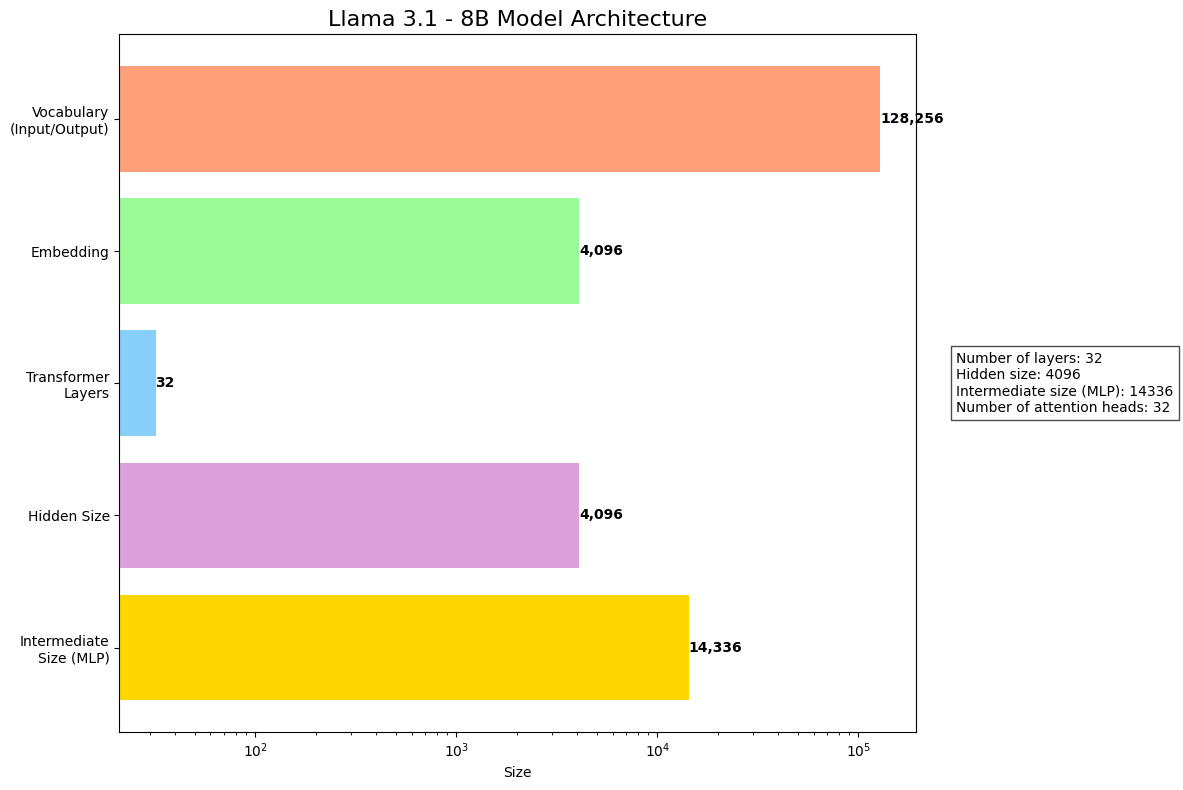

In [6]:
def create_reordered_model_viz(model):
    # Extract model dimensions
    vocab_size = model.model.embed_tokens.weight.shape[0]  # 128256
    hidden_size = model.model.embed_tokens.weight.shape[1]  # 4096
    num_layers = len(model.model.layers)  # 32
    num_heads = model.model.layers[0].self_attn.num_heads  # Assuming this is available
    intermediate_size = model.model.layers[0].mlp.gate_proj.out_features  # 14336

    # Define components in the desired order
    components = [
        ('Vocabulary\n(Input/Output)', vocab_size),
        ('Embedding', hidden_size),
        ('Transformer\nLayers', num_layers),
        ('Hidden Size', hidden_size),
        ('Intermediate\nSize (MLP)', intermediate_size)
    ]

    # Colors for each component
    colors = ['#FFA07A', '#98FB98', '#87CEFA', '#DDA0DD', '#FFD700']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create bar chart
    y_pos = np.arange(len(components))
    labels = [c[0] for c in components]
    sizes = [c[1] for c in components]
    bars = ax.barh(y_pos, sizes, align='center', color=colors)
    
    # Set y-ticks and labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    
    # Reverse the y-axis to have the first component at the top
    ax.invert_yaxis()

    # Add size labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{sizes[i]:,}', 
                ha='left', va='center', fontweight='bold')

    # Customize the plot
    ax.set_title('Llama 3.1 - 8B Model Architecture', fontsize=16)
    ax.set_xlabel('Size')
    ax.set_xscale('log')  # Use log scale for x-axis due to large differences in sizes

    # Add model details
    details = (f"Number of layers: {num_layers}\n"
               f"Hidden size: {hidden_size}\n"
               f"Intermediate size (MLP): {intermediate_size}\n"
               f"Number of attention heads: {num_heads}")
    ax.text(1.05, 0.5, details, transform=ax.transAxes, 
            verticalalignment='center', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    return fig

fig = create_reordered_model_viz(model)
plt.show()


The Llama 3.1 - 8B model architecture visualized here showcases a large language model with impressive capacity. At its core are 32 transformer layers, each operating on a hidden size of 4,096 dimensions. The model begins by embedding input tokens from a substantial vocabulary of 128,256 tokens into this 4,096-dimensional space. These embeddings then flow through the transformer layers, where self-attention mechanisms and feedforward neural networks process the information. Within each transformer layer, the intermediate size expands to 14,336 in the MLP (Multi-Layer Perceptron) sections, allowing for more complex computations before projecting back to the hidden size. This expansion and projection pattern is crucial for the model's expressive power. The model uses 32 attention heads, enabling it to focus on different aspects of the input simultaneously. Finally, the output is projected back to the full vocabulary size, enabling the model to predict the next token in a sequence. This architecture balances depth (32 layers) with width (4,096 hidden size), and the large vocabulary allows for nuanced token representations, contributing to the model's strong performance across various natural language tasks.

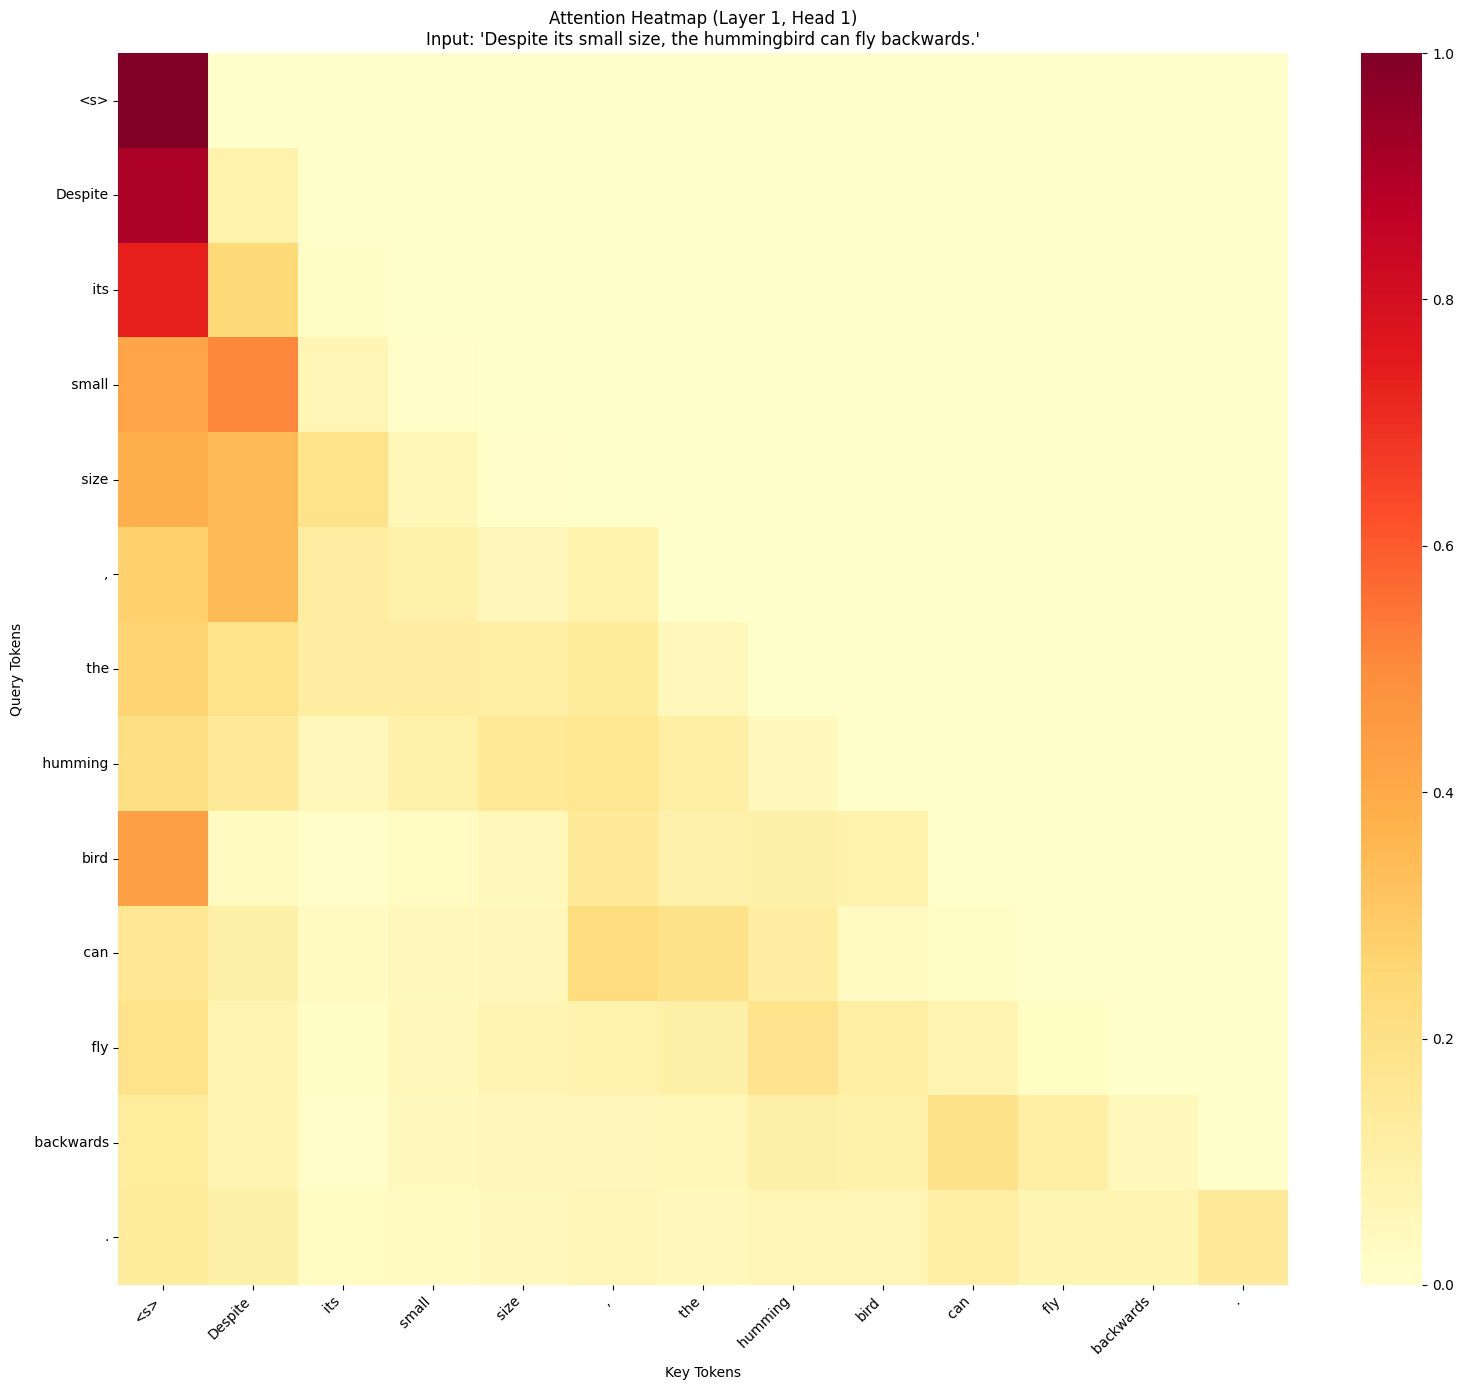

In [12]:
def visualize_attention(model, tokenizer, input_text, layer=0, head=0):
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")
    input_ids = inputs['input_ids'][0]
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions

    # Get attention weights for specified layer and head
    attention_weights = attentions[layer][0][head].cpu().numpy()

    # Get correct token labels
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Process tokens for display
    display_tokens = []
    for token in tokens:
        if token == '<|begin_of_text|>':
            display_tokens.append('<s>')
        elif token == '<|end_of_text|>':
            display_tokens.append('</s>')
        elif token.startswith('Ġ'):
            display_tokens.append(' ' + token[1:])  # Replace 'Ġ' with space for clarity
        else:
            display_tokens.append(token)
    
    # Create heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(attention_weights, annot=False, cmap="YlOrRd", xticklabels=display_tokens, yticklabels=display_tokens)
    
    plt.title(f"Attention Heatmap (Layer {layer+1}, Head {head+1})\nInput: '{input_text}'")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Example usage
input_text = "Despite its small size, the hummingbird can fly backwards."
visualize_attention(model, tokenizer, input_text, layer=0, head=0)

This attention heatmap for the sentence "Despite its small size, the hummingbird can fly backwards." reveals interesting patterns in how the model processes information in its first layer and first attention head. The start token '\<s>' shows strong attention across all tokens, suggesting its role in gathering context for the entire sentence. There's a notable pattern of local attention, where tokens attend strongly to their immediate neighbors, as seen in the diagonal pattern. The word "Despite" shows moderate attention to "small" and "size," indicating the model's awareness of the contrasting relationship it introduces. "Hummingbird" exhibits attention to "small" and "size," suggesting the model connects the bird's characteristics. Interestingly, "fly" and "backwards" show mutual attention, capturing their semantic relationship as the key action. The token "can" attends to both "hummingbird" and "fly," linking the subject to its ability. There's also a subtle attention from "backwards" to "Despite," potentially capturing the unexpected nature of the hummingbird's ability despite its size. This layer seems to focus on local grammatical structure and immediate semantic relationships, laying groundwork for higher-level understanding in subsequent layers.



In [11]:
def predict_next_token(input_text):
    inputs = tokenizer(input_text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    
    predicted_token_id = torch.argmax(logits[0, -1, :])
    predicted_word = tokenizer.decode(predicted_token_id)
    
    print(f"Input: '{input_text}'")
    print(f"Predicted next token: '{predicted_word}'")

predict_next_token("The capital of France is")

Input: 'The capital of France is'
Predicted next token: ' a'


In [21]:
# Iterate through all named parameters to see their names and types
for name, param in model.named_parameters():
    print(name, param.shape)

# You can also use named_modules to explore the submodules
for name, module in model.named_modules():
    print(name, module)


model.embed_tokens.weight torch.Size([128256, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 14336])
model.layers.0.input_layernorm.weight torch.Size([4096])
model.layers.0.post_attention_layernorm.weight torch.Size([4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([14336, 4096])
model.

Llama 3.1 8B Model Structure Summary
1. Overall Architecture

    Transformer-based, decoder-only variant
    Components: embedding layer, multiple transformer layers, output layer

2. Key Components
    a. Embedding Layer (model.embed_tokens)

    Converts input tokens to dense vector representations
    Dimension: 128256 x 4096

    b. Transformer Layers (model.layers)

    32 identical layers (numbered 0 to 31)
    Each layer contains:

    Self-Attention mechanism (self_attn)
    Multi-Layer Perceptron (mlp)
    Layer Normalization (input_layernorm and post_attention_layernorm)



    c. Output Layer (lm_head)

    Linear layer mapping final hidden states to vocabulary logits
    Dimension: 4096 x 128256

3. Detailed Layer Components
    a. Self-Attention (LlamaSdpaAttention)

    Query (q_proj), key (k_proj), and value (v_proj) projections
    Rotary positional embeddings (rotary_emb)
    Output projection (o_proj)

    b. Multi-Layer Perceptron (LlamaMLP)

    Gate and up projections expand dimension (4096 to 14336)
    SiLU activation function
    Down projection reduces dimensions back to 4096

    c. Layer Normalization

    Uses RMSNorm, a variant of Layer Normalization 

4. Model Dimensions

    Hidden state size: 4096
    Intermediate MLP size: 14336
    Number of attention heads: 32 (derived from 4096 / 128)

5. Activation Function

    SiLU (Sigmoid Linear Unit) used in the MLP

6. Notable Features

    Rotary positional embeddings instead of absolute positional encodings
    RMSNorm for layer normalization
    No bias terms in linear layers

    
This architecture enables effective processing of sequential data, capturing complex patterns and relationships in input text. With approximately 8 billion parameters, the model can learn and represent vast amounts of information, facilitating human-like text generation and various language tasks.

In [5]:
# Inspect the model to understand its structure
print(model)

# Access the first transformer block
first_block = model.model.layers[0]

# Print the first linear layer weights of the first transformer block
first_linear_layer_weights = first_block.mlp.gate_proj.weight
print(first_linear_layer_weights)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [18]:
# 4. Text Generation
def generate_text(input_text, max_length=50):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    
    attention_mask = inputs['attention_mask']
    pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id

    output_sequences = model.generate(
        inputs['input_ids'],
        attention_mask=attention_mask,
        max_length=max_length,
        do_sample=False,
        num_return_sequences=1,
        pad_token_id=pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    print(f"Input: '{input_text}'")
    print(f"Generated text: {generated_text}")

generate_text("""<|begin_of_text|>Capital of France is""")

Input: '<|begin_of_text|>Capital of France is'
Generated text: Capital of France is Paris, the city of love, fashion, art, and cuisine. Paris is a city that has been a major hub for centuries, with a rich history and culture that is still evident today. From the iconic Eiff


In [10]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Capital of France is"},
]
pipe = pipeline("text-generation", model="meta-llama/Meta-Llama-3.1-8B-Instruct", max_new_tokens=50, device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu"))
pipe(messages)

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': [{'role': 'user', 'content': 'Capital of France is'},
   {'role': 'assistant', 'content': 'The capital of France is Paris.'}]}]

In [12]:
from transformers import AutoTokenizer, pipeline

# Initialize the pipeline
pipe = pipeline("text-generation", model="meta-llama/Meta-Llama-3.1-8B-Instruct", device='mps')

# Access the tokenizer directly
tokenizer = pipe.tokenizer

# Example message
messages = [
    {"role": "user", "content": "Capital of France is"},
]

# Simulate what the pipeline does internally
input_text = messages[0]["content"]
tokenized_input = tokenizer(input_text, return_tensors="pt")

# Decode to see the formatted text
formatted_text = tokenizer.decode(tokenized_input['input_ids'][0], skip_special_tokens=False)
print(f"Formatted Text: {formatted_text}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Formatted Text: <|begin_of_text|>Capital of France is


In [14]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, TextGenerationPipeline

# Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

# If you want to inspect the processing within the pipeline:
class CustomPipeline(TextGenerationPipeline):
    def preprocess(self, inputs, **generate_kwargs):
        # Call the original preprocess method
        model_inputs = super().preprocess(inputs, **generate_kwargs)
        print(f"Preprocessed Inputs: {model_inputs}")
        return model_inputs

# Initialize the custom pipeline
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct").to(device)
custom_pipe = CustomPipeline(model=model, tokenizer=tokenizer, device=device, max_new_tokens=50)

# Generate and inspect
custom_pipe(messages)



Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Preprocessed Inputs: {'input_ids': tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271, 128009, 128006,
            882, 128007,    271,  64693,    315,   9822,    374, 128009, 128006,
          78191, 128007,    271]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'prompt_text': <transformers.pipelines.text_generation.Chat object at 0x17feb6d40>}


[{'generated_text': [{'role': 'user', 'content': 'Capital of France is'},
   {'role': 'assistant', 'content': 'The capital of France is Paris.'}]}]

In [15]:
# 5. Inference Parameters Exploration

def explore_inference_parameters(input_text, temperatures=[0.3, 0.7, 1.0], top_p_values=[0.3, 0.7, 1.0]):
    # Use the updated method to check for MPS availability
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
    model.to(device)
    
    # Set pad_token to eos_token
    tokenizer.pad_token = tokenizer.eos_token
    
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    for temp in temperatures:
        for top_p in top_p_values:
            output = model.generate(
                inputs['input_ids'],
                attention_mask=attention_mask,
                max_length=60,
                temperature=temp,
                top_p=top_p,
                do_sample=True,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
            
            generated_text = tokenizer.decode(output[0].cpu(), skip_special_tokens=True)
            print(f"Temperature: {temp}, Top-p: {top_p}")
            print(f"Generated: {generated_text}\n")

starting_input = "In a distant future, humanity discovered a hidden power within the stars. This power could be harnessed to"

explore_inference_parameters(starting_input)

Temperature: 0.3, Top-p: 0.3
Generated: In a distant future, humanity discovered a hidden power within the stars. This power could be harnessed to create incredible technologies, but it came at a terrible cost. The stars themselves began to fade, and the fabric of space-time started to unravel. The people of Earth were faced with a

Temperature: 0.3, Top-p: 0.7
Generated: In a distant future, humanity discovered a hidden power within the stars. This power could be harnessed to create a new form of energy, one that could sustain entire civilizations. The discovery of this power, known as the "Stellar Energy," marked a new era in human history.
As

Temperature: 0.3, Top-p: 1.0
Generated: In a distant future, humanity discovered a hidden power within the stars. This power could be harnessed to create immense energy, but at a terrible cost. The energy, known as the "Starlight," was found to be a manifestation of the universe's own life force. As humans began

Temperature: 0.7, Top-p: 0.3
G

In [19]:
def register_hooks(model):
    activations = []

    def hook_fn(module, input, output):
        # Check if output is a tuple and extract the first element if it is
        if isinstance(output, tuple):
            activations.append(output[0])
        else:
            activations.append(output)

    hooks = []
    for i, layer in enumerate(model.model.layers):
        hooks.append(layer.register_forward_hook(hook_fn))
    
    return hooks, activations

def analyze_layers(input_text):
    # Tokenize the input text and move it to the appropriate device
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Register hooks to capture the activations
    hooks, activations = register_hooks(model)

    # Run the model to trigger the hooks
    _ = model(**inputs)
    
    # Now activations list will have outputs from each layer
    print(f"Analyzing LLaMA 3.1 8B model layers for input: '{input_text}'\n")
    for i, activation in enumerate(activations):
        # Compute statistics for each layer's output
        mean_val = activation.mean().item()
        std_val = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()
        
        # Print the statistics for this layer
        print(f"Layer {i + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Std Dev: {std_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print()
    
    # Remove hooks after analysis
    for hook in hooks:
        hook.remove()

    print("Layer analysis completed.")

# Example input text for analysis
starting_input = "In the distant future, humanity has mastered the art of interstellar travel."

analyze_layers(starting_input)

Analyzing LLaMA 3.1 8B model layers for input: 'In the distant future, humanity has mastered the art of interstellar travel.'

Layer 1:
  Mean: 0.0002
  Std Dev: 0.0491
  Min: -2.5502
  Max: 3.2153

Layer 2:
  Mean: -0.0052
  Std Dev: 2.0646
  Min: -294.0639
  Max: 321.5550

Layer 3:
  Mean: -0.0053
  Std Dev: 2.0651
  Min: -294.1276
  Max: 321.6336

Layer 4:
  Mean: -0.0051
  Std Dev: 2.0660
  Min: -294.2521
  Max: 321.7295

Layer 5:
  Mean: -0.0045
  Std Dev: 2.0672
  Min: -294.3688
  Max: 321.7903

Layer 6:
  Mean: -0.0047
  Std Dev: 2.0685
  Min: -294.5399
  Max: 321.8500

Layer 7:
  Mean: -0.0047
  Std Dev: 2.0699
  Min: -294.6727
  Max: 321.9390

Layer 8:
  Mean: -0.0044
  Std Dev: 2.0714
  Min: -294.8217
  Max: 322.0103

Layer 9:
  Mean: -0.0043
  Std Dev: 2.0726
  Min: -294.9132
  Max: 322.0692

Layer 10:
  Mean: -0.0050
  Std Dev: 2.0736
  Min: -294.9958
  Max: 322.1019

Layer 11:
  Mean: -0.0051
  Std Dev: 2.0838
  Min: -296.2489
  Max: 323.7329

Layer 12:
  Mean: -0.0048
  S

### Layer-wise Analysis of LLaMA 3.1 8B Model

This section provides a detailed analysis of the activations for each layer of the LLaMA 3.1 8B model when processing the input text:

**Input Text:** "In the distant future, humanity has mastered the art of interstellar travel."

#### General Structure:
- **Layer X:** Refers to the Xth layer of the model.
  - **Mean:** The average value of all activations in the layer.
  - **Std Dev:** The standard deviation, representing the spread or variability of the activations.
  - **Min:** The minimum activation value in the layer.
  - **Max:** The maximum activation value in the layer.

#### Key Observations:

1. **Early Layers (Layer 1):**
   - **Mean:** 0.0002
   - **Std Dev:** 0.0491
   - **Min:** -2.5502
   - **Max:** 3.2153
   - **Interpretation:** Early layers have tightly clustered activations around zero with small variability, focusing on basic feature extraction.

2. **Middle Layers (Layer 2 - Layer 31):**
   - **Mean:** -0.0052 (Layer 2) to -0.0123 (Layer 31)
   - **Std Dev:** Ranges from 2.0646 to 2.1899
   - **Min/Max:** Values range from -297.1374 to 324.7462 across these layers.
   - **Interpretation:** These layers exhibit high variability and wide activation ranges, indicating significant transformations and complex feature extraction.

3. **Final Layer (Layer 32):**
   - **Mean:** -0.0007
   - **Std Dev:** 1.0558
   - **Min:** -21.9441
   - **Max:** 22.8590
   - **Interpretation:** The final layer shows reduced variability and a narrower range, indicating that the model is consolidating the information into a more stable output.

#### Summary:
- **Activation Variability:** Increasing standard deviation in middle layers suggests intensive processing and abstraction.
- **Activation Range:** Extreme values in middle layers reflect the model's complex transformations, while the final layer shows a consolidation of features.
- **Final Layer:** Reduced variability and range, preparing for a cohesive and interpretable output.

This analysis helps to understand the progression of information processing within the LLaMA 3.1 8B model, highlighting the role of each layer in transforming the input text into a final representation.


In [29]:
import torch.nn.functional as F

def rank_candidates(input_text, candidates):
    # Device management
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
    
    # Tokenize input text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    logprobs = {}

    for candidate in candidates:
        # Tokenize candidate and combine with input text
        candidate_ids = tokenizer(candidate, return_tensors="pt").input_ids.to(device)
        combined_ids = torch.cat((input_ids, candidate_ids), dim=-1)
        
        with torch.no_grad():
            # Get logits for all tokens in the candidate in a single forward pass
            output = model(input_ids=combined_ids)
            logits = output.logits[:, input_ids.size(1)-1:-1, :]

        # Compute log probabilities for each token in the candidate
        logprobs_step = F.log_softmax(logits, dim=-1)
        candidate_logprobs = logprobs_step.gather(2, candidate_ids.unsqueeze(-1)).squeeze(-1)
        
        # Sum log probabilities to get the total log probability for the candidate
        total_logprob = candidate_logprobs.sum().item()
        
        logprobs[candidate] = total_logprob

    # Sort candidates by their log probability in descending order
    sorted_candidates = sorted(logprobs.items(), key=lambda x: x[1], reverse=True)
    
    # Output the ranked candidates
    print(f"Input: '{input_text}'")
    print("Ranked candidates:")
    for candidate, logprob in sorted_candidates:
        print(f"  '{candidate}': {logprob:.4f}")

# Example usage
rank_candidates("The capital of India is Delhi, what is the capital of France? It is", ["Paris", " Berlin", " London"])


Input: 'The capital of India is Delhi, what is the capital of France? It is'
Ranked candidates:
  ' Berlin': -32.8896
  'Paris': -33.6316
  ' London': -33.7240


In [20]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="meta-llama/Meta-Llama-3.1-8B-Instruct", max_new_tokens=50, device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu"))
pipe(messages)

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': 'I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."'}]}]

In [27]:
import inspect
# Access the underlying model and tokenizer
model = pipe.model
tokenizer = pipe.tokenizer

# Inspect the generate method's signature to see default values
print("Generate method default parameters:")
print(inspect.signature(model.generate))

Generate method default parameters:
(inputs: Optional[torch.Tensor] = None, generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None, logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None, stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None, prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None, synced_gpus: Optional[bool] = None, assistant_model: Optional[ForwardRef('PreTrainedModel')] = None, streamer: Optional[ForwardRef('BaseStreamer')] = None, negative_prompt_ids: Optional[torch.Tensor] = None, negative_prompt_attention_mask: Optional[torch.Tensor] = None, **kwargs) -> Union[transformers.generation.utils.GenerateDecoderOnlyOutput, transformers.generation.utils.GenerateEncoderDecoderOutput, transformers.generation.utils.GenerateBeamDecoderOnlyOutput, transformers.generation.utils.GenerateBeamEncoderDecoderOutput, torch.LongTens

In [28]:
# View the model's default configuration
print("Model configuration parameters:")
print(model.config)

Model configuration parameters:
LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 128256
}



In [30]:
# Access the tokenizer and model
tokenizer = pipe.tokenizer

# Prepare the input message
messages = [{"role": "user", "content": "Who are you?"}]

# You might need to convert the input to a format similar to what the pipeline does
input_text = messages[0]["content"]

# Tokenize the input
tokenized_input = tokenizer(input_text, return_tensors="pt")
print("Tokenized input:", tokenized_input)


Tokenized input: {'input_ids': tensor([[128000,  15546,    527,    499,     30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}


In [33]:
tokenizer.decode(tokenized_input['input_ids'].squeeze().tolist(), skip_special_tokens=True)

'Who are you?'

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Set the pad_token to eos_token
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Prepare the input message
messages = [
    {"role": "user", "content": "Who are you?"},
]

# Convert the input message to a single string (assuming one message)
input_text = messages[0]["content"]

# Tokenize the input text and create attention mask
inputs = tokenizer(input_text, return_tensors="pt", padding=True)
input_ids = inputs.input_ids
attention_mask = inputs.attention_mask

# Move tensors to the appropriate device (CUDA or MPS or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
model = model.to(device)

# Generate the output with attention mask
output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)

# Decode the generated token IDs to text
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(output_text)



Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


Who are you? Who is your family?
I am a 5-year-old, 10-month-old, and a 6-month-old child. My family is a loving and supportive one, and we are all excited to start this new chapter in our lives. My
